Link for this notebook:
https://colab.research.google.com/drive/1xCX8cd0lMo3brD4IIYpdVEkhAqSh1SJS?usp=sharing


# **Analysing the Impact of Sustainable Development Goals on Life Expectancy**




## **Introduction**
this assignment  will analyse the impact of Sustainable Development Goals (SDGs) on Life Expectancy. Relevant data will be collected from data.worldbank.org, specifically using the World Development Indicators DataBank Links to an external site. for the period of 2000-2016. The dataset provides information for different countries, and will only consider low income, lower middle income, and upper middle income countries by using the provided filter in the DataBank. In this DataBank, the Life Expectancy is encoded as Life expectancy at birth, total (years). The following SDG indicators (SDGIs) from this DataBank as features will be used to predict Life Expectancy:

- SDG 1: GNI per capita, PPP (current international $) (NY.GNP.PCAP.PP.CD)
- SDG 2: Prevalence of undernourishment (% of population) (SN.ITK.DEFC.ZS), Food production index (2014-2016 = 100) (AG.PRD.FOOD.XD)
- SDG 3: Prevalence of HIV, total (% of population ages 15-49) (SH.DYN.AIDS.ZS), Fertility rate, total (births per woman) (SP.DYN.TFRT.IN)
- SDG 4: School enrollment, primary (% net) (SE.PRM.NENR), School enrollment, secondary (% net) (SE.SEC.NENR)
- SDG 5: Labor force participation rate, female (% of female population ages 15+) (national estimate) (SL.TLF.CACT.FE.NE.ZS), Proportion of seats held by women in national parliaments (%) (SG.GEN.PARL.ZS)
- SDG 6: People using at least basic drinking water services (% of population)
- SDG 7: Access to electricity (% of population) (EG.ELC.ACCS.ZS)
- SDG 8: Unemployment with basic education (% of total labor force with basic education) (SL.UEM.BASC.ZS)
- SDG 11: Urban population (% of total population), Population living in slums (% of urban population) (EN.POP.SLUM.UR.ZS)
- SDG 12: Population density (people per sq. km of land area) (EN.POP.DNST)
- SDG 13: CO2 emissions (metric tons per capita) (EN.ATM.CO2E.PC)
- SDG 15: Forest area (% of land area) (AG.LND.FRST.ZS)
- SDG 17: Military expenditure (% of GDP) (MS.MIL.XPND.GD.ZS)

##**Task**

1. Data Collection: Collect the relevant data from data.worldbank.org for the period of 2000-2016 using the World Development Indicators DataBank

2. Links to an external site.. Filter the dataset to include only low income, lower middle income, and upper middle income countries.

3. Data Preprocessing: Apply necessary data preprocessing steps. Drop the records with missing values if the resulting dataset has an adequate number of data points. Otherwise, remove features with a significant number of missing values.

4. Exploratory Data Analysis: Perform exploratory data analysis on the preprocessed dataset. Analyse the relationships between different SDGIs and Life Expectancy. Provide visualisations and insights based on your observations.

5. Linear Regression Model: Build a basic linear regression pipeline using PySpark. Train the model on the preprocessed dataset and test its performance using appropriate evaluation metrics.

6. Random Forest Regression Model: Build a basic random forest regression pipeline using PySpark. Train the model on the preprocessed dataset and test its performance using appropriate evaluation metrics.

7. Model Parameter Analysis: Analyse the model parameters from both linear regression and random forest regression models. Interpret the parameters based on feature importance from the perspective of SDGIs and their impact on Life Expectancy.

8. Conclusion: Summarise findings and provide a concise analysis of the relationship between SDGs and Life Expectancy. Reflect on the strengths and limitations of the models used and suggest potential improvements



# **Global Constants**

In [1]:
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
GDRIVE_DIR = "/content/gdrive"
GDRIVE_HOME_DIR = GDRIVE_DIR + "/My Drive"
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + "/BDC Datasets"
DATASET_URL = "https://ndownloader.figstatic.com/files/SDG_Data.csv"
GDRIVE_DATASET_FILE = GDRIVE_DATA_DIR + "/" + DATASET_URL.split("/")[-1]

RANDOM_SEED = 42 # for reproducibility

# **Spark + Google Colab Setup**

## **1.** Install PySpark and related dependencies

In [2]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = JAVA_HOME

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
openjdk-8-jdk-headless is already the newest version (8u372-ga~us1-0ubuntu1~20.04).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


## **2.** Import useful Python packages

In [3]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

## **3.** Create Spark context

In [4]:
conf = SparkConf().set("spark.ui.port", "4050").set('spark.executor.memory', '4G').set('spark.driver.memory', '45G').set('spark.driver.maxResultSize', '10G')
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

## **5.** Link Colab to our Google Drive

In [5]:
from google.colab import drive
drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/gdrive


## **6.** Check everything is ok

In [6]:
spark

In [7]:
sc._conf.getAll()

[('spark.driver.memory', '45G'),
 ('spark.driver.port', '39127'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.driver.maxResultSize', '10G'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.se

# **1. Data Collection**

### **Download dataset file from URL directly to our Google Drive**

In [8]:
def get_data(dataset_url, dest, chunk_size=1024):
  response = requests.get(dataset_url, stream=True)
  if response.status_code == 200:
    with open(dest, "wb") as file:
      for block in response.iter_content(chunk_size=chunk_size): 
        if block: 
          file.write(block)

In [9]:
print("Retrieving dataset from URL: {} ...".format(DATASET_URL))
get_data(DATASET_URL, GDRIVE_DATASET_FILE)
print("Dataset successfully retrieved and stored at: {}".format(GDRIVE_DATASET_FILE))

Retrieving dataset from URL: https://ndownloader.figstatic.com/files/SDG_Data.csv ...
Dataset successfully retrieved and stored at: /content/gdrive/My Drive/BDC Datasets/SDG_Data.csv


### **Read dataset file into a Spark Dataframe**

In [10]:
sdg_df = spark.read.load(GDRIVE_DATASET_FILE, 
                         format="csv", 
                         sep=",", 
                         inferSchema="true", 
                         header="true"
                         )

In [11]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(sdg_df.count(), len(sdg_df.columns)))

The shape of the dataset is 2317 rows by 23 columns


In [12]:
sdg_df.printSchema()

root
 |-- Country Name: string (nullable = true)
 |-- Country Code: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Time Code: string (nullable = true)
 |-- Life expectancy at birth, total (years) [SP.DYN.LE00.IN]: string (nullable = true)
 |-- GNI per capita, PPP (current international $) [NY.GNP.PCAP.PP.CD]: string (nullable = true)
 |-- Prevalence of undernourishment (% of population) [SN.ITK.DEFC.ZS]: string (nullable = true)
 |-- Food production index (2014-2016 = 100) [AG.PRD.FOOD.XD]: string (nullable = true)
 |-- Prevalence of HIV, total (% of population ages 15-49) [SH.DYN.AIDS.ZS]: string (nullable = true)
 |-- Fertility rate, total (births per woman) [SP.DYN.TFRT.IN]: string (nullable = true)
 |-- School enrollment, primary (% net) [SE.PRM.NENR]: string (nullable = true)
 |-- School enrollment, secondary (% net) [SE.SEC.NENR]: string (nullable = true)
 |-- Labor force participation rate, female (% of female population ages 15+) (national estimate) [SL.TLF.

In [13]:
sdg = sdg_df

sdg = sdg.withColumnRenamed("Life expectancy at birth, total (years) [SP.DYN.LE00.IN]", "SP.DYN.LE00.IN")
sdg = sdg.withColumnRenamed("GNI per capita, PPP (current international $) [NY.GNP.PCAP.PP.CD]", "NY.GNP.PCAP.PP.CD")
sdg = sdg.withColumnRenamed("Prevalence of undernourishment (% of population) [SN.ITK.DEFC.ZS]", "SN.ITK.DEFC.ZS")
sdg = sdg.withColumnRenamed("Food production index (2014-2016 = 100) [AG.PRD.FOOD.XD]", "AG.PRD.FOOD.XD")
sdg = sdg.withColumnRenamed("Prevalence of HIV, total (% of population ages 15-49) [SH.DYN.AIDS.ZS]", "SH.DYN.AIDS.ZS")
sdg = sdg.withColumnRenamed("Fertility rate, total (births per woman) [SP.DYN.TFRT.IN]", "SP.DYN.TFRT.IN")
sdg = sdg.withColumnRenamed("School enrollment, primary (% net) [SE.PRM.NENR]", "SE.PRM.NENR")
sdg = sdg.withColumnRenamed("School enrollment, secondary (% net) [SE.SEC.NENR]", "SE.SEC.NENR")
sdg = sdg.withColumnRenamed("Labor force participation rate, female (% of female population ages 15+) (national estimate) [SL.TLF.CACT.FE.NE.ZS]", "SL.TLF.CACT.FE.NE.ZS")
sdg = sdg.withColumnRenamed("Proportion of seats held by women in national parliaments (%) [SG.GEN.PARL.ZS]", "SG.GEN.PARL.ZS")
sdg = sdg.withColumnRenamed("People using at least basic drinking water services (% of population) [SH.H2O.BASW.ZS]", "SH.H2O.BASW.ZS")
sdg = sdg.withColumnRenamed("Access to electricity (% of population) [EG.ELC.ACCS.ZS]", "EG.ELC.ACCS.ZS")
sdg = sdg.withColumnRenamed("Population living in slums (% of urban population) [EN.POP.SLUM.UR.ZS]", "EN.POP.SLUM.UR.ZS")
sdg = sdg.withColumnRenamed("Unemployment with basic education (% of total labor force with basic education) [SL.UEM.BASC.ZS]", "SL.UEM.BASC.ZS")
sdg = sdg.withColumnRenamed("Population density (people per sq. km of land area) [EN.POP.DNST]", "EN.POP.DNST")
sdg = sdg.withColumnRenamed("CO2 emissions (metric tons per capita) [EN.ATM.CO2E.PC]", "EN.ATM.CO2E.PC")
sdg = sdg.withColumnRenamed("Forest area (% of land area) [AG.LND.FRST.ZS]", "AG.LND.FRST.ZS")
sdg = sdg.withColumnRenamed("Military expenditure (% of GDP) [MS.MIL.XPND.GD.ZS]", "MS.MIL.XPND.GD.ZS")
sdg = sdg.withColumnRenamed("Urban population (% of total population) [SP.URB.TOTL.IN.ZS]", "SP.URB.TOTL.IN.ZS")

for column in sdg.columns:
    standard_name = column.lower().replace(" ", "_").replace(".", "_")
    sdg = sdg.withColumnRenamed(column, standard_name)


In [14]:
all_columns = sdg.columns
index = all_columns.index("sp_dyn_le00_in")
columns_to_cast = all_columns[index:]

for column in columns_to_cast:
    sdg = sdg.withColumn(column, sdg[column].cast("double"))
sdg.printSchema()

root
 |-- country_name: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- time: integer (nullable = true)
 |-- time_code: string (nullable = true)
 |-- sp_dyn_le00_in: double (nullable = true)
 |-- ny_gnp_pcap_pp_cd: double (nullable = true)
 |-- sn_itk_defc_zs: double (nullable = true)
 |-- ag_prd_food_xd: double (nullable = true)
 |-- sh_dyn_aids_zs: double (nullable = true)
 |-- sp_dyn_tfrt_in: double (nullable = true)
 |-- se_prm_nenr: double (nullable = true)
 |-- se_sec_nenr: double (nullable = true)
 |-- sl_tlf_cact_fe_ne_zs: double (nullable = true)
 |-- sg_gen_parl_zs: double (nullable = true)
 |-- sh_h2o_basw_zs: double (nullable = true)
 |-- eg_elc_accs_zs: double (nullable = true)
 |-- en_pop_slum_ur_zs: double (nullable = true)
 |-- sl_uem_basc_zs: double (nullable = true)
 |-- en_pop_dnst: double (nullable = true)
 |-- en_atm_co2e_pc: double (nullable = true)
 |-- ag_lnd_frst_zs: double (nullable = true)
 |-- ms_mil_xpnd_gd_zs: double (nullable = t

In [15]:
sdg = sdg.replace('', None)
sdg = sdg.replace('..', None)

for c in sdg.columns:
  print("N. of missing values of column `{:s}` = {:d}".format(c, sdg.where(col(c).isNull()).count()))

N. of missing values of column `country_name` = 3
N. of missing values of column `country_code` = 5
N. of missing values of column `time` = 5
N. of missing values of column `time_code` = 5
N. of missing values of column `sp_dyn_le00_in` = 37
N. of missing values of column `ny_gnp_pcap_pp_cd` = 142
N. of missing values of column `sn_itk_defc_zs` = 573
N. of missing values of column `ag_prd_food_xd` = 92
N. of missing values of column `sh_dyn_aids_zs` = 481
N. of missing values of column `sp_dyn_tfrt_in` = 35
N. of missing values of column `se_prm_nenr` = 918
N. of missing values of column `se_sec_nenr` = 1354
N. of missing values of column `sl_tlf_cact_fe_ne_zs` = 1294
N. of missing values of column `sg_gen_parl_zs` = 200
N. of missing values of column `sh_h2o_basw_zs` = 43
N. of missing values of column `eg_elc_accs_zs` = 57
N. of missing values of column `en_pop_slum_ur_zs` = 1459
N. of missing values of column `sl_uem_basc_zs` = 1632
N. of missing values of column `en_pop_dnst` = 34


### **Implementation Explanation**

Looking at the null character number of the above columns some to the features will be dropped due to them having too many null values which will remove too many rows if thier not dropped. 

In [16]:
sdg = sdg.drop('sl_uem_basc_zs')
sdg = sdg.drop('en_pop_slum_ur_zs')
sdg = sdg.drop('sl_tlf_cact_fe_ne_zs')
sdg = sdg.drop('se_sec_nenr')
sdg = sdg.drop('se_prm_nenr')


sdg = sdg.dropna()

for c in sdg.columns:
  print("N. of missing values of column `{:s}` = {:d}".format(c, sdg.where(col(c).isNull()).count()))

print("The shape of the dataset is {:d} rows by {:d} columns".format(sdg.count(), len(sdg.columns)))

N. of missing values of column `country_name` = 0
N. of missing values of column `country_code` = 0
N. of missing values of column `time` = 0
N. of missing values of column `time_code` = 0
N. of missing values of column `sp_dyn_le00_in` = 0
N. of missing values of column `ny_gnp_pcap_pp_cd` = 0
N. of missing values of column `sn_itk_defc_zs` = 0
N. of missing values of column `ag_prd_food_xd` = 0
N. of missing values of column `sh_dyn_aids_zs` = 0
N. of missing values of column `sp_dyn_tfrt_in` = 0
N. of missing values of column `sg_gen_parl_zs` = 0
N. of missing values of column `sh_h2o_basw_zs` = 0
N. of missing values of column `eg_elc_accs_zs` = 0
N. of missing values of column `en_pop_dnst` = 0
N. of missing values of column `en_atm_co2e_pc` = 0
N. of missing values of column `ag_lnd_frst_zs` = 0
N. of missing values of column `ms_mil_xpnd_gd_zs` = 0
N. of missing values of column `sp_urb_totl_in_zs` = 0
The shape of the dataset is 1215 rows by 18 columns


### **Implementation Explanation**

The dataset has taken a significant reduction in data points, but more removal of the features could mean removing important features. The features removed had 1000 or more missing datasets which is almost half of the data size which is why they were removed

# **3. Exploratory Data Analysis**

In [17]:
sdg_df = sdg
sdg_df.describe().show()

+-------+------------+------------+------------------+---------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|country_name|country_code|              time|time_code|   sp_dyn_le00_in|ny_gnp_pcap_pp_cd|    sn_itk_defc_zs|    ag_prd_food_xd|    sh_dyn_aids_zs|    sp_dyn_tfrt_in|    sg_gen_parl_zs|    sh_h2o_basw_zs|    eg_elc_accs_zs|       en_pop_dnst|    en_atm_co2e_pc|    ag_lnd_frst_zs| ms_mil_xpnd_gd_zs| sp_urb_totl_in_zs|
+-------+------------+------------+------------------+---------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|    

In [18]:
INDEX_FEATURE = "country_code"
NUMERICAL_FEATURES = ["ny_gnp_pcap_pp_cd",
                      "sn_itk_defc_zs",
                      "ag_prd_food_xd",
                      "sh_dyn_aids_zs",
                      "sp_dyn_tfrt_in", 
                      "sg_gen_parl_zs",
                      "sh_h2o_basw_zs", 
                      "eg_elc_accs_zs", 
                      "en_pop_dnst",
                      "en_atm_co2e_pc",
                      "ag_lnd_frst_zs",
                      "ms_mil_xpnd_gd_zs",
                      "sp_urb_totl_in_zs",
                      ]
                  
CATEGORICAL_FEATURES = []

TARGET_VARIABLE = "sp_dyn_le00_in"

### **Implementation Explanation**

The data is all numerical continous value. They are a percentage, total, proportion(which can also be considered a percentage)

In [19]:
sdg_pdf = sdg_df.toPandas() 

In [20]:
sns.set_style("darkgrid")
sns.set_context("notebook", rc={"lines.linewidth": 2, 
                                "xtick.labelsize":14, 
                                "ytick.labelsize":14,
                                "axes.labelsize": 18
                                })

### **Distribution Plots**

The following feature will **not** be included:
- `country_name`
- `country_code`
- `time`
- `time_code`

In [21]:
# Select only the columns which will be included in the distribution plots
PLOT_COLUMNS = sorted(NUMERICAL_FEATURES + [TARGET_VARIABLE])
print("Plotting {:d} columns from the dataset:\n[{:s}]".format(len(PLOT_COLUMNS), 
                                                              ", ".join(["`{:s}`".format(pc) for pc in PLOT_COLUMNS])
                                                              ))

Plotting 14 columns from the dataset:
[`ag_lnd_frst_zs`, `ag_prd_food_xd`, `eg_elc_accs_zs`, `en_atm_co2e_pc`, `en_pop_dnst`, `ms_mil_xpnd_gd_zs`, `ny_gnp_pcap_pp_cd`, `sg_gen_parl_zs`, `sh_dyn_aids_zs`, `sh_h2o_basw_zs`, `sn_itk_defc_zs`, `sp_dyn_le00_in`, `sp_dyn_tfrt_in`, `sp_urb_totl_in_zs`]


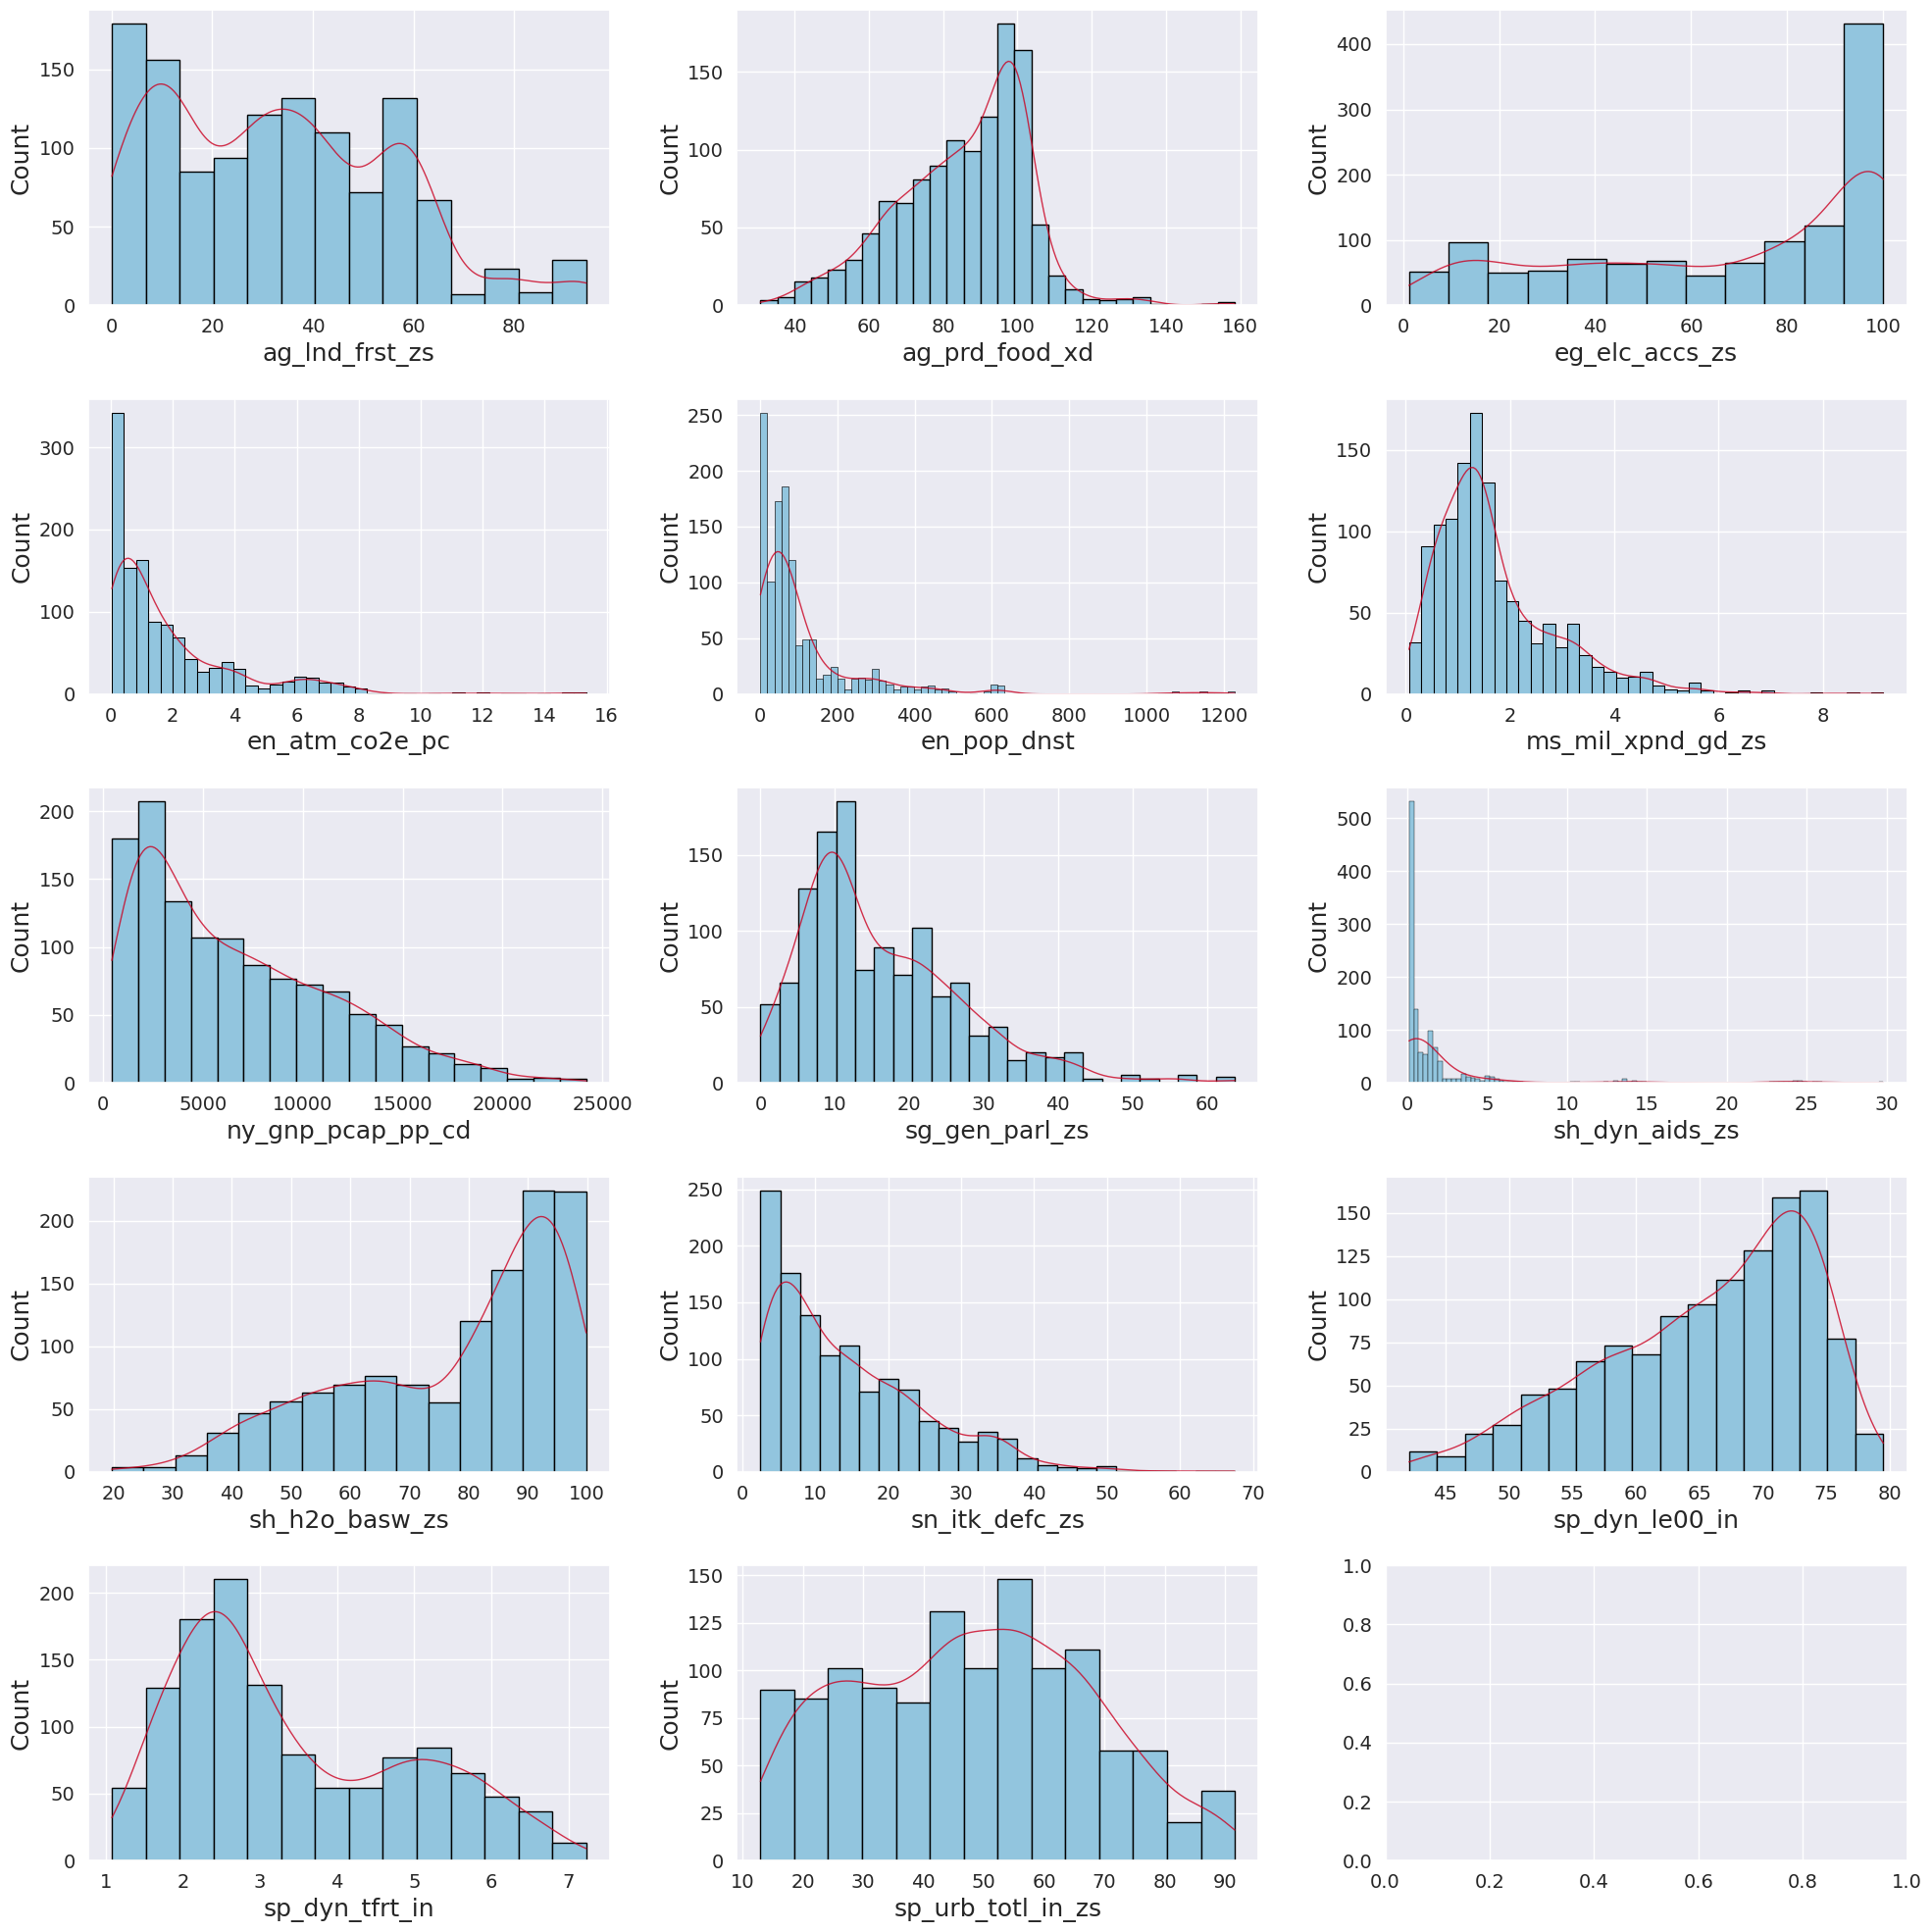

In [22]:
n_rows = 5
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,20))

for i, f in enumerate(PLOT_COLUMNS):
  _ = sns.histplot(sdg_pdf[f],
                   kde=True,
                   color="#ca0020",
                   #kde_kws={"linewidth": 1},
                   line_kws={"linewidth": 1, "alpha": 0.8},
                   facecolor="#92c5de",
                   edgecolor="black",
                   ax=axes[i//n_cols, i%n_cols]
                   )

fig.tight_layout(pad=1.5)

In [23]:
NUMERICAL_CONTINUOUS_FEATURES = sorted(list(set(NUMERICAL_FEATURES) ))
print("Regression plots of {:d} numerical continuous features:\n[{:s}]".format(len(NUMERICAL_CONTINUOUS_FEATURES),
                                                                              ", ".join(["`{:s}`".format(ncf) for ncf in NUMERICAL_CONTINUOUS_FEATURES])
                                                                              ))

Regression plots of 13 numerical continuous features:
[`ag_lnd_frst_zs`, `ag_prd_food_xd`, `eg_elc_accs_zs`, `en_atm_co2e_pc`, `en_pop_dnst`, `ms_mil_xpnd_gd_zs`, `ny_gnp_pcap_pp_cd`, `sg_gen_parl_zs`, `sh_dyn_aids_zs`, `sh_h2o_basw_zs`, `sn_itk_defc_zs`, `sp_dyn_tfrt_in`, `sp_urb_totl_in_zs`]


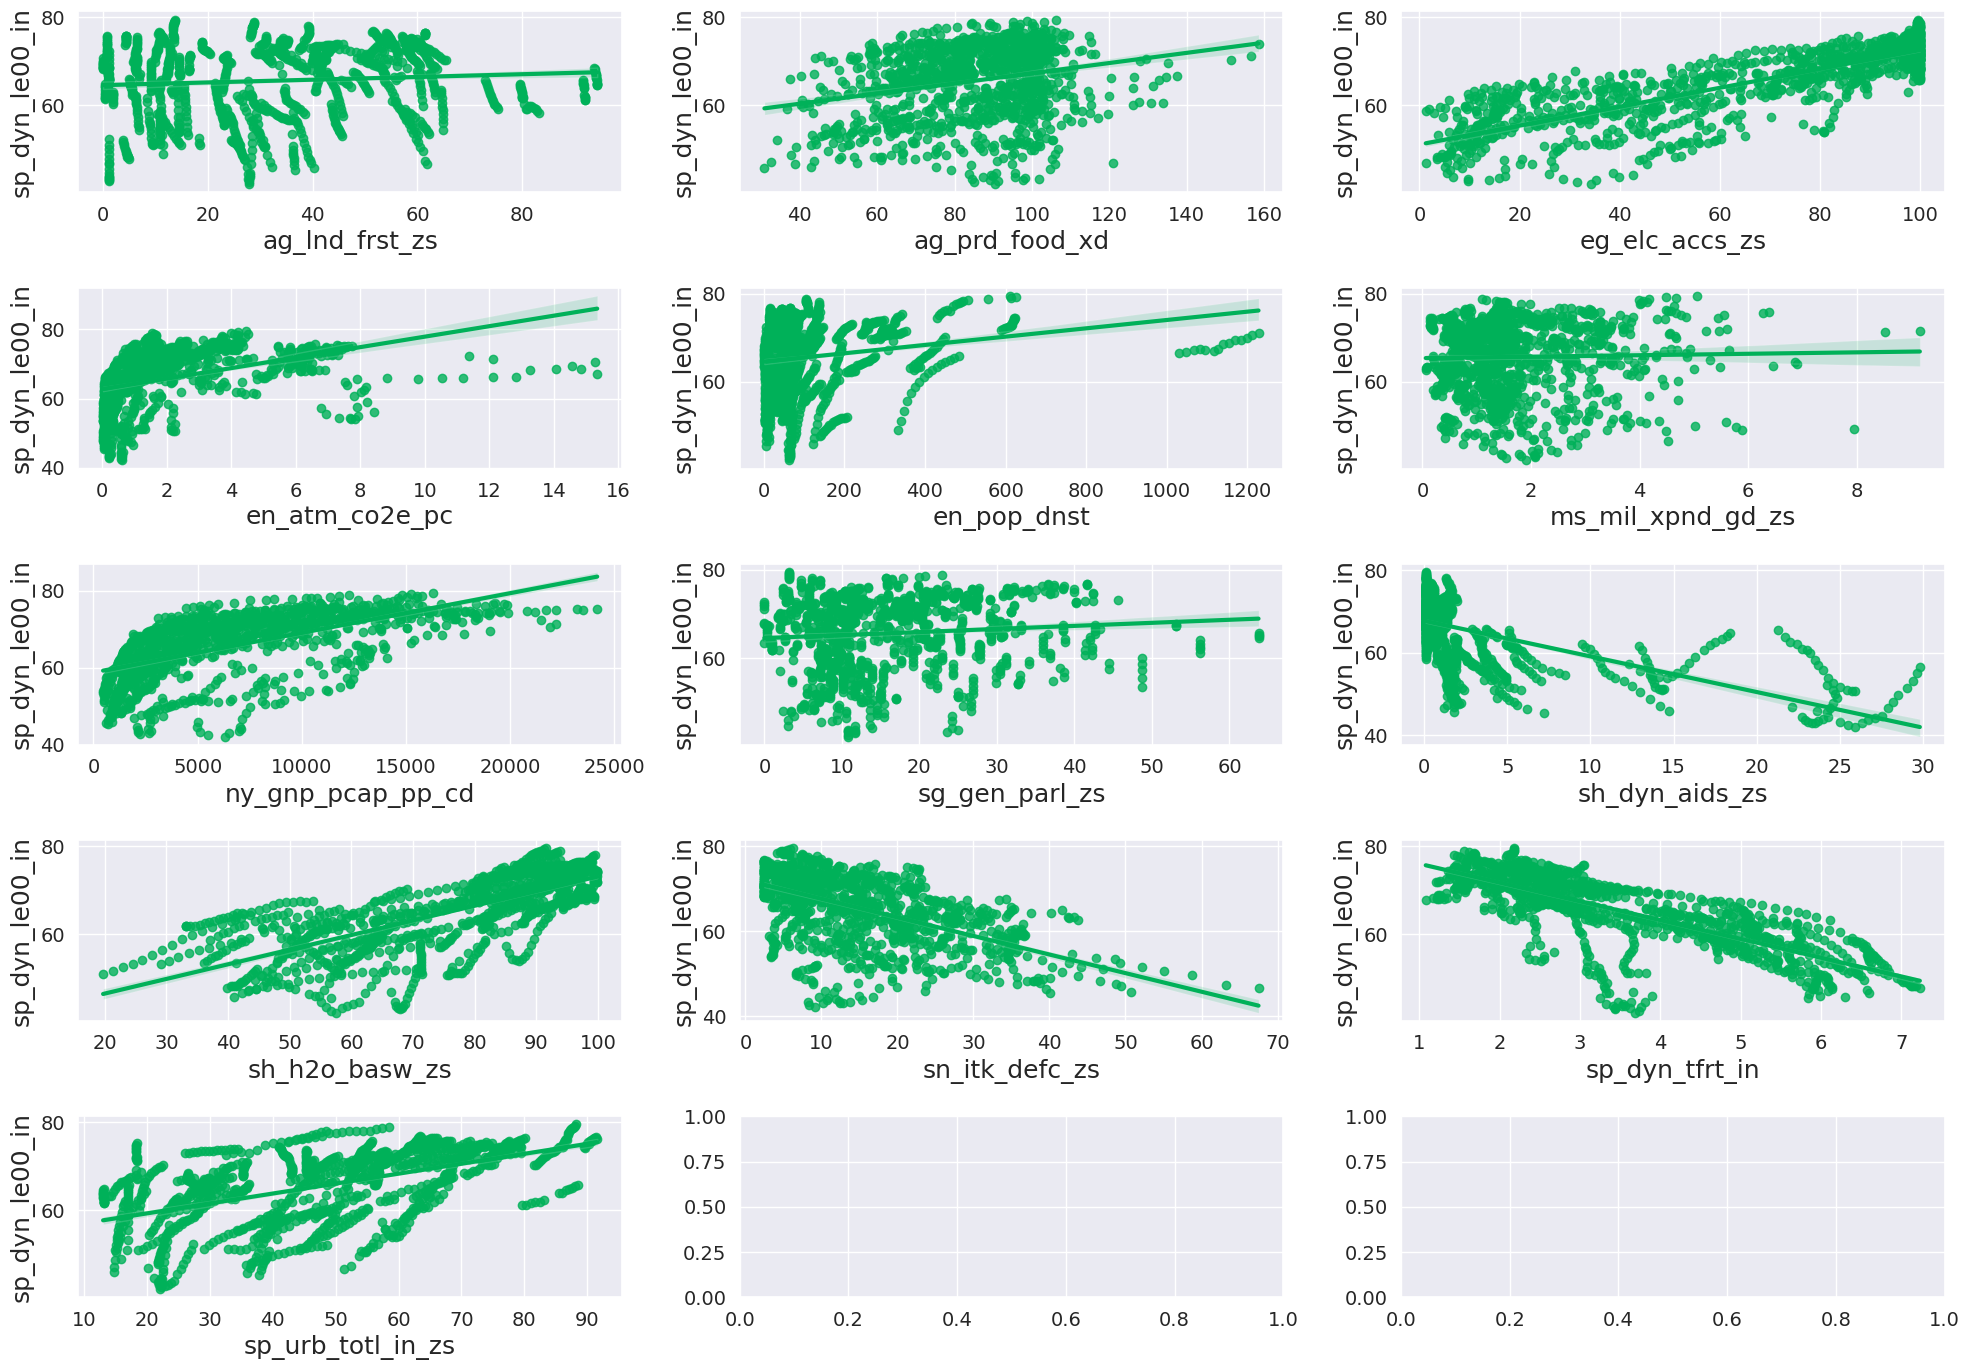

In [24]:
# Plot the relationship between each continuous feature (i.e., independent variable) with the target (i.e., dependent) variable
n_rows = 5
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,14))

for i,f in enumerate(NUMERICAL_CONTINUOUS_FEATURES):
  _ = sns.regplot(data=sdg_pdf, 
                  x=f, 
                  y="sp_dyn_le00_in",
                  color="#00b159",
                  ax=axes[i//n_cols, i%n_cols])

fig.tight_layout(pad=1.5)

#### **Observations**

It seems there is a moderate/strong linear relationship between `sp_dyn_tfrt_in`, `sh_h2o_basw_zs`, `eg_elc_accs_zs` and `sp_dyn_le0o_in`. 

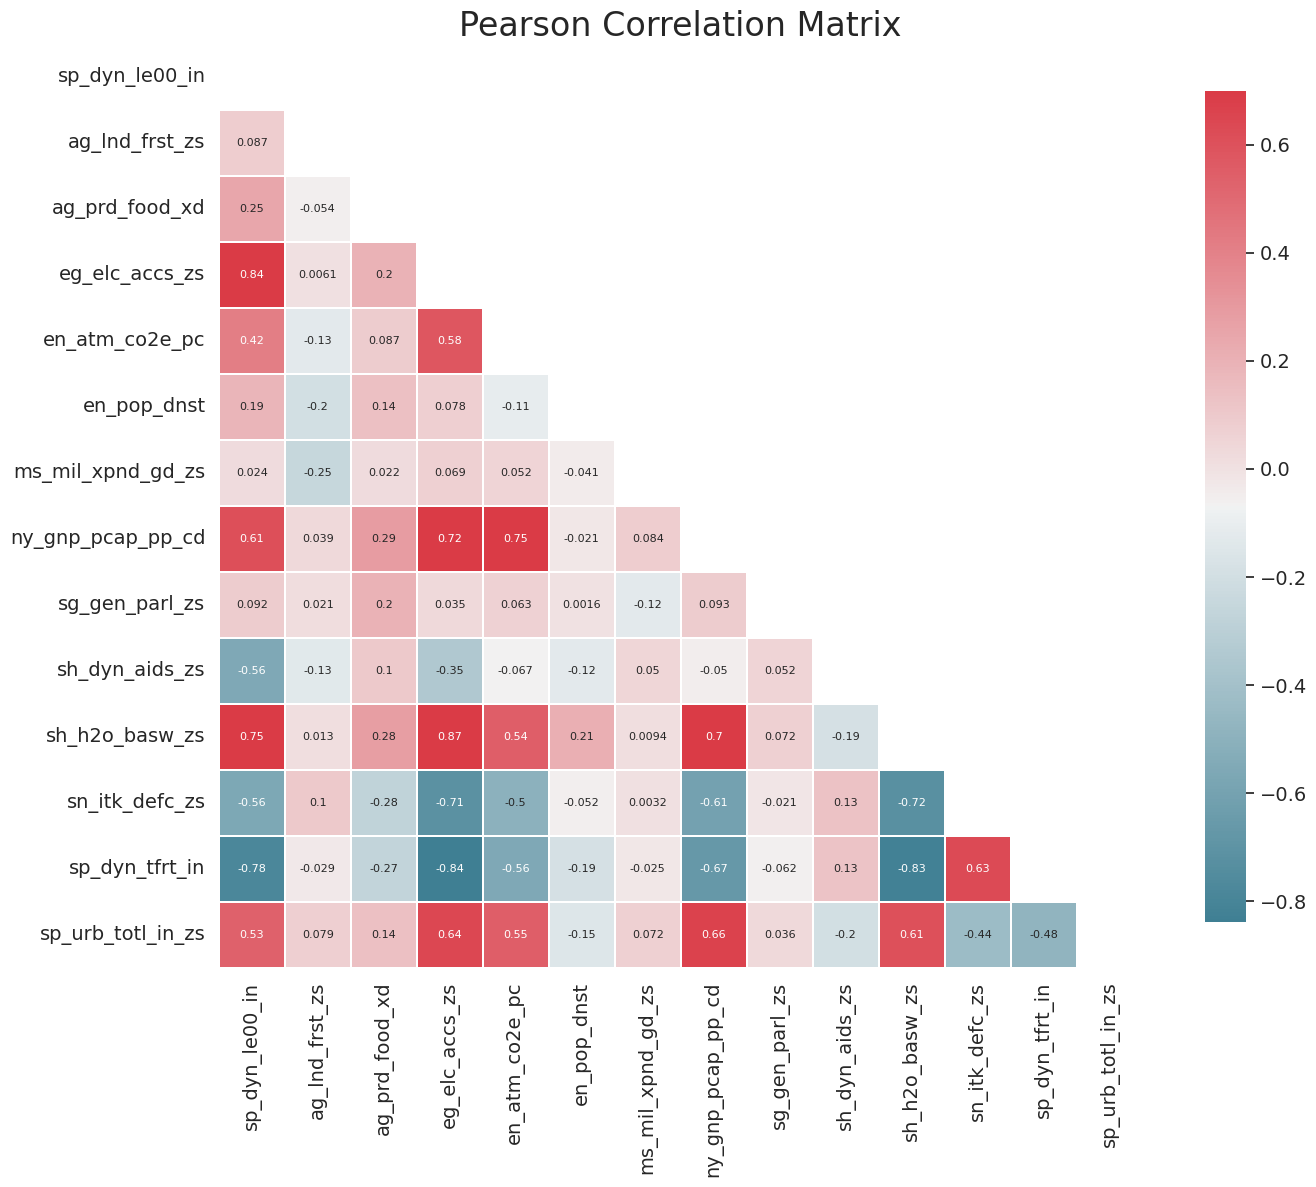

In [25]:
# Select the features we want to use to compute the correlation matrix (i.e., everything except `id` and `date`)
features = [TARGET_VARIABLE] + sorted(NUMERICAL_FEATURES)

mask = np.zeros_like(sdg_pdf[features].corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True 

with sns.axes_style("white"): # Temporarily set the background to white
  fig, ax = plt.subplots(figsize=(16, 12))
  plt.title('Pearson Correlation Matrix', fontsize=24)

  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  _ = sns.heatmap(sdg_pdf[features].corr(), 
              linewidths=0.25, 
              vmax=0.7, 
              square=True,
              ax=ax, 
              cmap=cmap, 
              linecolor='w', 
              annot=True, 
              annot_kws={"size":8}, 
              mask=mask, 
              cbar_kws={"shrink": .9});

# **4. Linear Regression Model**

In [26]:
train_df, test_df = sdg_df.randomSplit([0.9, 0.1], seed=RANDOM_SEED)

In [27]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols= NUMERICAL_FEATURES, outputCol='features')

simple_train_df = assembler.transform(train_df)

In [28]:
simple_train_df = simple_train_df.select(["features", "sp_dyn_le00_in"])
simple_train_df.show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+
|features                                                                                                                                               |sp_dyn_le00_in|
+-------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+
|[1570.0,23.3,93.57,0.1,6.235,27.3092369477912,45.78160949,46.7400512695313,41.9871931680542,0.178123619355445,1.85278199408184,2.08741255278385,23.528]|60.364        |
|[1770.0,21.2,93.0,0.1,6.099,27.710843373494,48.28708366,42.7000007629395,43.2204467749107,0.252083458083514,1.85278199408184,1.94583569418812,23.737]  |60.851        |
|[1750.0,20.2,88.65,0.1,5.958,27.710843373494,50.8278463,43.2220191955566,44.8448507428361,0.30525973791313,1.85278199408184,1.82134545354632,23.948]   |61

In [29]:
from pyspark.ml.regression import LinearRegression

# First of all, let's just setup a very basic OLS linear regressor (i.e., univariate with no regularizatio term)
lr = LinearRegression(featuresCol="features", labelCol="sp_dyn_le00_in")
# Train the actual model on our training set `simple_train_df`
lr_model = lr.fit(simple_train_df)

In [30]:
training_result = lr_model.summary
print("***** Training Set *****")
print("RMSE: {:.3f}".format(training_result.rootMeanSquaredError))
print("R2: {:.3f}".format(training_result.r2))
print("Adjusted R2: {:.3f}".format(training_result.r2adj))
print("***** Training Set *****")

***** Training Set *****
RMSE: 2.770
R2: 0.885
Adjusted R2: 0.884
***** Training Set *****


In [31]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols= NUMERICAL_FEATURES, 
                            outputCol="features")

simple_test_df = assembler.transform(test_df)

In [32]:
lr_predictions = lr_model.transform(simple_test_df) 

In [33]:
lr_predictions.select("features", "prediction", "sp_dyn_le00_in").show(5)

+--------------------+------------------+--------------+
|            features|        prediction|sp_dyn_le00_in|
+--------------------+------------------+--------------+
|[2150.0,21.5,95.9...|62.225903423202396|        62.659|
|[4440.0,4.9,65.87...| 70.63528516433608|        75.639|
|[5570.0,42.9,68.2...| 58.15136532917731|        54.633|
|[6660.0,15.4,102....| 60.67755457463903|        61.092|
|[11640.0,2.5,82.7...| 73.50023512320628|        68.811|
+--------------------+------------------+--------------+
only showing top 5 rows



In [34]:
test_result = lr_model.evaluate(simple_test_df)
print("***** Test Set *****")
print("RMSE: {:.3f}".format(test_result.rootMeanSquaredError))
print("R2: {:.3f}".format(test_result.r2))
print("Adjusted R2: {:.3f}".format(test_result.r2adj))
print("***** Test Set *****")

***** Test Set *****
RMSE: 2.991
R2: 0.862
Adjusted R2: 0.842
***** Test Set *****


# **5. Random Forest Regression Model**

In [35]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

In [36]:
assembler = VectorAssembler(inputCols= NUMERICAL_FEATURES, outputCol='features')
output_data = assembler.transform(sdg_df)

In [37]:
train_df, test_df = output_data.randomSplit([0.9, 0.1], seed=RANDOM_SEED)

In [38]:
rf = RandomForestRegressor(featuresCol="features", labelCol = "sp_dyn_le00_in")

In [39]:
model = rf.fit(train_df)

In [40]:
predictions = model.transform(test_df)

In [41]:
predictions.select("prediction", "sp_dyn_le00_in", "features").show(5)

+-----------------+--------------+--------------------+
|       prediction|sp_dyn_le00_in|            features|
+-----------------+--------------+--------------------+
|63.23974469460759|        62.659|[2150.0,21.5,95.9...|
|71.48802452383316|        75.639|[4440.0,4.9,65.87...|
|55.73048855200652|        54.633|[5570.0,42.9,68.2...|
|58.97428315751089|        61.092|[6660.0,15.4,102....|
|72.21950924490116|        68.811|[11640.0,2.5,82.7...|
+-----------------+--------------+--------------------+
only showing top 5 rows



In [42]:
evaluator = RegressionEvaluator(labelCol='sp_dyn_le00_in', predictionCol='prediction', metricName='mse')
mse = evaluator.evaluate(predictions)

# You can also calculate additional evaluation metrics
rmse = evaluator.evaluate(predictions, {evaluator.metricName: 'rmse'})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: 'r2'})

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 3.6138331422113223
Root Mean Squared Error (RMSE): 1.9010084540083778
R-squared (R2): 0.9441029560863664


# **6. Model Parameter Analysis**

#### **Intercept ($\theta_0$) and Coefficient ($\theta_1$) for Linear regression**

In [43]:
print("Intercept: " + str(lr_model.intercept))
print("Coefficient: " + str(lr_model.coefficients))

Intercept: 67.55530810496538
Coefficient: [0.0004208380953181745,0.031187477730941777,0.029968783034769075,-0.6945130881203444,-2.7403811389939903,0.039690957550688556,0.00756397416845818,0.04489016314581062,1.598472922658616e-06,-0.7722055293959752,-0.01121102380375301,0.05722989838532508,0.017179291109681912]


It can be seen based on these two predictive models that these features can help predict life expentancy. Based on the RMSE of the linear regression the prediction has a margin of error of two percent. 

# **7. Conclusion**

Linear regression and Random Forest Model can predict life expetancy accuratley. Potential improvements include crossValidation in both linear regression and Random Forest Regression Model. Limitations were was the dataset needed to drop features which could also affect the Predictability of the models